# testing without processor: edit features and cuts
Only `TTGamma` data, distinguishing prompt photons from fake photons

* `ak.flatten` instead of `ak.pad_none`
* Remove jet & muon features
* Remove 1 photon requirement. How to include `photon_count` feature?
* Add cut: pho-jet $\Delta R > 0.4$. ??? histograms look correct, but column accumulators have an issue

In [1]:
from coffea import hist, util

#import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
#Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }

filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [3]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

In [4]:
# events from TTGamma
events = NanoEventsFactory.from_root(fileset["TTGamma"][0],
                                     schemaclass=SkimmedSchema,
                                     entry_stop=100000).events()

dataset = "TTGamma"

In [5]:
# muon cuts
muons = events.Muon
muonSelectTight = ((muons.pt>30) &
                   (abs(muons.eta)<2.4) &
                   (muons.tightId) &
                   (muons.pfRelIso04_all < 0.15)
                  )
tightMuons = muons[muonSelectTight]

In [6]:
# jet & b-tagged jet cuts
jets = events.Jet

jetSelectTight = ((jets.pt>30) &
                  (abs(jets.eta)<2.4) &
                  (jets.isTight)
                 )
btaggedJetSelect = (jetSelectTight &
                   (jets.btagDeepB>0.6321)
                  )

tightJets = jets[jetSelectTight]
tightBJets = jets[btaggedJetSelect]

In [7]:
# electron cuts
electrons = events.Electron
electronSelectTight = ((electrons.pt> 35) &
                       (abs(electrons.eta)<2.1) &
                       (electrons.cutBased>=4)
                      )
tightEle = electrons[electronSelectTight]

In [8]:
## Delta R cuts ##
phoMu, phoMuDR = events.Photon.nearest(tightMuons,return_metric=True)
phoMuMask = ak.fill_none(phoMuDR>0.4,True)

phoJet, phoJetDR = events.Photon.nearest(tightJets,return_metric=True)
phoJetMask = ak.fill_none(phoJetDR>0.4,True)

In [9]:
phoJetMask

<Array [[True], [True, ... [False, False]] type='100000 * var * bool'>

In [10]:
phoMuMask

<Array [[True], [True, ... [True, True]] type='100000 * var * bool'>

In [11]:
# photon cuts
photons = events.Photon
photonSelect= ((photons.pt > 20) &
               (abs(photons.eta) < 1.4442) &
               (photons.isScEtaEE | photons.isScEtaEB) &
               (photons.electronVeto) &
               np.invert(photons.pixelSeed) &
               phoJetMask & phoMuMask)
tightPhotons = photons[photonSelect]
tightPhotons

<PhotonArray [[Photon], [], [], ... [], [], []] type='100000 * var * photon'>

In [12]:
phoMu2, phoMuDR2 = tightPhotons.nearest(tightMuons,return_metric=True)
phoJet2, phoJetDR2 = tightPhotons.nearest(tightJets,return_metric=True)

In [13]:
print('Pho:',tightPhotons)
print('Mu: ',tightMuons)
print('DR: ',phoMuDR2)

Pho: [[Photon], [], [], [], [], [], [], [Photon, ... [], [], [], [], [Photon], [], [], []]
Mu:  [[Muon], [], [], [Muon], [], [], [], [], ... [], [], [], [], [], [], [], [Muon]]
DR:  [[1.87], [], [], [], [], [], [], [None], ... [], [], [], [], [None], [], [], []]


In [14]:
# event cuts
trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24

eventSelection = (trigger &
                  (ak.num(tightMuons)==1) &
                  (ak.num(tightJets)>=4) & 
                  (ak.num(tightBJets)>=1) &
                  (ak.num(tightEle)==0) &
                  (ak.num(tightPhotons)>=1))

In [15]:
##### histograms #####

In [303]:
dataset_axis = hist.Cat("dataset","Dataset")

photon_pt_axis = hist.Bin("pt","photon $p_{T}$ [GeV]", 40, 0, 400)
photon_eta_axis = hist.Bin("eta","photon $\eta$", 50, -2.5, 2.5)
photon_phi_axis = hist.Bin("phi","photon $\phi$", 64, -3.2, 3.2)
photon_reliso_all_axis = hist.Bin("reliso","photon pfRelIso03_all", 40, -0.5, 6)
photon_reliso_chg_axis = hist.Bin("reliso","photon pfRelIso03_chg", 40, -0.5, 6)
photon_sieie_axis = hist.Bin("sieie","photon sigma I eta I eta", 40, 0, 0.05)
photon_r9_axis = hist.Bin("r9","photon R9", 40, -0.5, 1.5)
photon_hoe_axis = hist.Bin("hoe","photon H over E", 40, -0.5, 1)
photon_count_axis = hist.Bin("count","Photon number",12,-1,10)

deltar_axis = hist.Bin("deltar","$\Delta R$", 50, -0.5, 4)

photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",[0,1,13,14])

In [304]:
photon_pt_hist = hist.Hist("Counts", dataset_axis, photon_pt_axis, photon_genPartFlav_axis)
photon_eta_hist = hist.Hist("Counts", dataset_axis, photon_eta_axis)
photon_phi_hist = hist.Hist("Counts", dataset_axis, photon_phi_axis)
photon_reliso_all_hist = hist.Hist("Counts", dataset_axis, photon_reliso_all_axis)
photon_reliso_chg_hist = hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis)
photon_sieie_hist = hist.Hist("Counts", dataset_axis, photon_sieie_axis)
photon_r9_hist = hist.Hist("Counts", dataset_axis, photon_r9_axis)
photon_hoe_hist = hist.Hist("Counts", dataset_axis, photon_hoe_axis)
photon_count_hist = hist.Hist("Counts", dataset_axis, photon_count_axis)

deltaR_photon_lepton_hist = hist.Hist("Counts", dataset_axis, deltar_axis)
deltaR_photon_jet_hist = hist.Hist("Counts", dataset_axis, deltar_axis)

photon_genPartFlav_hist = hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis)

In [305]:
dataset

'TTGamma'

In [306]:
flavLabel = ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav))
flavLabel[flavLabel == 13] = 0

flavLabel

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [307]:
photon_pt_hist.fill(dataset=dataset,
                    pt=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)),
                    flav=flavLabel)
photon_eta_hist.fill(dataset=dataset,
                     eta=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)))
photon_phi_hist.fill(dataset=dataset,
                     phi=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)))
photon_reliso_all_hist.fill(dataset=dataset,
                            reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)))
photon_reliso_chg_hist.fill(dataset=dataset,
                            reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)))
photon_sieie_hist.fill(dataset=dataset,
                       sieie=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)))
photon_r9_hist.fill(dataset=dataset,
                    r9=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)))
photon_hoe_hist.fill(dataset=dataset,
                     hoe=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)))
photon_count_hist.fill(dataset=dataset,
                       count=(ak.num(tightPhotons[eventSelection])))

deltaR_photon_lepton_hist.fill(dataset=dataset,
                               deltar=ak.to_numpy(ak.flatten(phoMuDR2[eventSelection])))
deltaR_photon_jet_hist.fill(dataset=dataset,
                            deltar=ak.to_numpy(ak.flatten(phoJetDR2[eventSelection])))

photon_genPartFlav_hist.fill(dataset=dataset,
                             flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))

In [308]:
photon_pt_hist.sum('dataset').identifiers('flav')

[<Interval ([0, 1)) instance at 0x7f288845f790>,
 <Interval ([1, 13)) instance at 0x7f288845f520>,
 <Interval ([13, 14)) instance at 0x7f288845fd00>]

In [309]:
legopts = {}

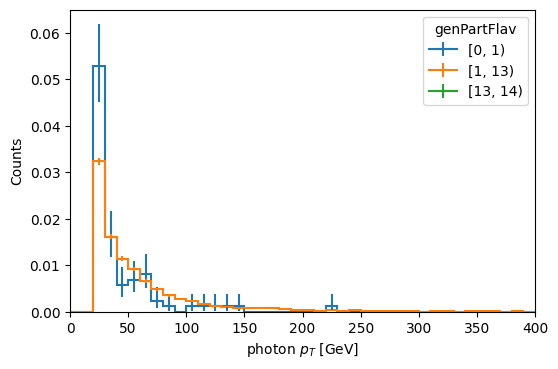

In [310]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(photon_pt_hist.sum('dataset'),overlay='flav',stack=False,density=True,legend_opts=legopts)
plt.show()

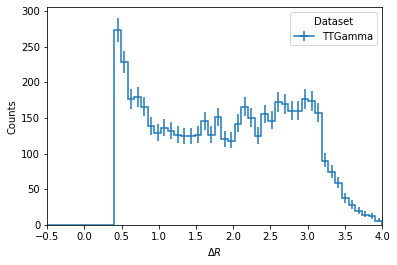

In [275]:
hist.plot1d(deltaR_photon_lepton_hist,overlay='dataset',stack=False)#,density=True)
plt.show()

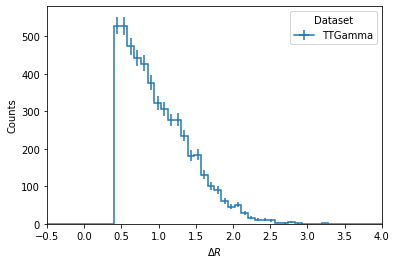

In [195]:
hist.plot1d(deltaR_photon_jet_hist,overlay='dataset',stack=False)#,density=True)
plt.show()

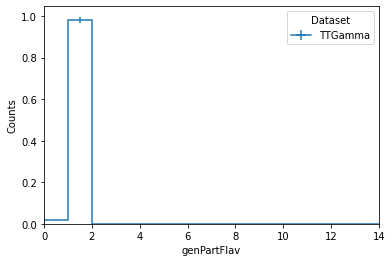

In [196]:
hist.plot1d(photon_genPartFlav_hist,overlay='dataset',stack=False,density=True)
plt.show()

In [23]:
###### column accumulators #######

In [24]:
photon_pt = ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))
photon_eta = ak.to_numpy(ak.flatten(tightPhotons.eta[eventSelection]))
photon_phi = ak.to_numpy(ak.flatten(tightPhotons.phi[eventSelection]))
photon_pfRelIso03_all = ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_all[eventSelection]))
photon_pfRelIso03_chg = ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_chg[eventSelection]))
photon_sieie = ak.to_numpy(ak.flatten(tightPhotons.sieie[eventSelection]))
photon_r9 = ak.to_numpy(ak.flatten(tightPhotons.r9[eventSelection]))
photon_hoe = ak.to_numpy(ak.flatten(tightPhotons.hoe[eventSelection]))

dim = ak.to_numpy(ak.num(tightPhotons[eventSelection]))
photon_count = ak.to_numpy(ak.num(tightPhotons[eventSelection]))

deltaR_photon_lepton = ak.to_numpy(ak.flatten(phoMuDR2[eventSelection]))
deltaR_photon_jet = ak.to_numpy(ak.flatten(phoJetDR2[eventSelection]))

photon_genPartFlav = ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection]))


In [25]:
photon_count.shape

(5068,)

In [26]:
dim = ak.to_numpy(ak.num(tightPhotons[eventSelection]))
print(dim) # number photons in each event
print(dim.shape) # number of events

[1 1 1 ... 1 1 1]
(5068,)


In [27]:
ak.to_numpy(ak.flatten(tightPhotons[eventSelection])).shape # number of photons

(5116,)

In [28]:
photon_pt.shape

(5116,)

In [29]:
np.array(photon_pt).shape

(5116,)

In [30]:
np.array(deltaR_photon_lepton).shape

(5116,)

In [31]:
####### processing for machine learning #######

In [32]:
df = pd.DataFrame({
    'photon_pt': np.array(photon_pt),
    'photon_eta': np.array(photon_eta),
    'photon_phi': np.array(photon_phi),
    'photon_hoe': np.array(photon_hoe),
    'photon_r9': np.array(photon_r9),
    'photon_sieie': np.array(photon_sieie),
    'photon_pfRelIso03_all': np.array(photon_pfRelIso03_all),
    'photon_pfRelIso03_chg': np.array(photon_pfRelIso03_chg),
    #'photon_count': np.array(photon_count), ### different shape than other features...
    'photon_genPartFlav': np.array(photon_genPartFlav),  ## target ##
    
    'deltaR_photon_lepton': np.array(deltaR_photon_lepton),
    'deltaR_photon_jet': np.array(deltaR_photon_jet),
})
df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,photon_genPartFlav,deltaR_photon_lepton,deltaR_photon_jet
count,5116.000000,5116.000000,5116.000000,5116.000000,5116.000000,5116.000000,5116.000000,5116.000000,5116.000000,5116.000000,5116.000000
mean,59.952549,0.006127,-0.008706,0.007878,0.907753,0.009229,0.025399,0.008796,0.985536,1.880019,0.983297
std,56.287415,0.726107,1.828545,0.022221,0.118157,0.000994,0.123751,0.031931,0.211557,0.934318,0.442698
min,20.004042,-1.442139,-3.139648,0.000000,0.253906,0.000196,0.000000,0.000000,0.000000,0.401427,0.400469
25%,26.340275,-0.566803,-1.591858,0.000000,0.919434,0.008850,0.000000,0.000000,1.000000,1.024057,0.620709
50%,41.054747,0.014345,-0.032413,0.000000,0.956055,0.009186,0.001203,0.000000,1.000000,1.897456,0.889666
75%,68.960909,0.569946,1.564819,0.004738,0.966309,0.009501,0.020961,0.003302,1.000000,2.686922,1.264794
max,550.472412,1.442871,3.141113,0.487305,1.092773,0.022308,5.257202,0.731495,13.000000,4.511411,3.276965


In [33]:
df.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,photon_genPartFlav,deltaR_photon_lepton,deltaR_photon_jet
0,35.281075,1.013672,-2.959961,0.024109,0.959473,0.010345,0.018126,0.000000,1,0.673868,0.433896
1,49.449341,-0.927979,0.476990,0.000000,0.489990,0.009041,0.000000,0.000000,1,0.424922,0.429203
2,28.769894,-0.589233,-0.331116,0.000000,0.764160,0.008560,0.083477,0.083477,1,2.511429,0.605962
3,31.101566,0.875122,-0.901123,0.000000,0.967773,0.009857,0.000000,0.000000,1,1.692268,1.213066
4,152.660461,0.046585,-1.978027,0.005081,0.966797,0.008659,0.000000,0.000000,1,1.430684,0.719516


In [34]:
df['photon_genPartFlav'].value_counts()

1     5029
0       86
13       1
Name: photon_genPartFlav, dtype: int64

In [35]:
df = df[(df['photon_genPartFlav'] == 1) | (df['photon_genPartFlav'] == 0)]

In [36]:
df['photon_genPartFlav'].value_counts()

1    5029
0      86
Name: photon_genPartFlav, dtype: int64

In [37]:
# split into features and labels
X = np.array(df.drop(['photon_genPartFlav'],axis=1))
y = df['photon_genPartFlav']

# shuffle & split into training, validation, testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape)
print(y_train.max())
print(y_train.min())

(3069, 10)
1
0


In [38]:
print(y_test.max())
print(y_test.min())
print(y_val.max())
print(y_val.min())

1
0
1
0


In [39]:
# Scale: mean=0, stdev=1
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [40]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=128)

Epoch 1/10
24/24 [==============================] - 0s 1ms/step - loss: 0.5233 - accuracy: 0.8892
Epoch 2/10
24/24 [==============================] - 0s 1ms/step - loss: 0.3116 - accuracy: 0.9834
Epoch 3/10
24/24 [==============================] - 0s 1ms/step - loss: 0.2019 - accuracy: 0.9834
Epoch 4/10
24/24 [==============================] - 0s 1ms/step - loss: 0.1426 - accuracy: 0.9834
Epoch 5/10
24/24 [==============================] - 0s 1ms/step - loss: 0.1051 - accuracy: 0.9834
Epoch 6/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0782 - accuracy: 0.9840
Epoch 7/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0613 - accuracy: 0.9860
Epoch 8/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0520 - accuracy: 0.9889
Epoch 9/10
24/24 [==============================] - 0s 2ms/step - loss: 0.0466 - accuracy: 0.9902
Epoch 10/10
24/24 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.9909


In [42]:
loss, accuracy = model.evaluate(X_test_scaled,y_test,verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.03868
Test accuracy: 0.9912


In [43]:
y_pred = model.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

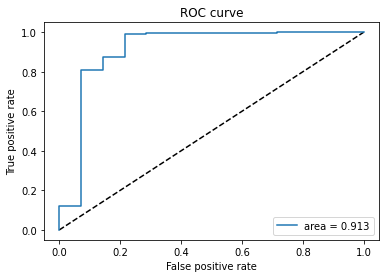

In [44]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [45]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

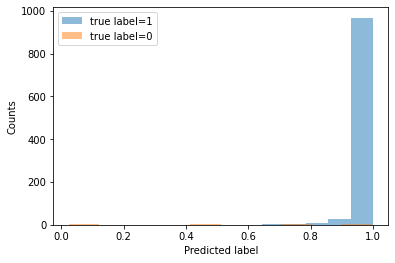

In [46]:
plt.hist(predTrue,alpha=0.5,label='true label=1')
plt.hist(predFalse,alpha=0.5,label='true label=0')

plt.xlabel('Predicted label')
plt.ylabel('Counts')
plt.title('')
plt.legend(loc='best')
plt.show()